In [1]:
import numpy as np
import torch as t
from torch.distributions import MultivariateNormal as MvNormal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget
from ipywidgets import FloatSlider, IntSlider, interact, interact_manual

$$
\newcommand{\bracket}[3]{\left#1 #3 \right#2}
\newcommand{\b}{\bracket{(}{)}}
\newcommand{\Bernoulli}{{\rm Bernoulli}\b}
\newcommand{\x}{\mathbf{x}}
\newcommand{\X}{\mathbf{X}}
\newcommand{\m}{\boldsymbol{\mu}}
\newcommand{\P}{{\rm P}\b}
\newcommand{\dd}[2][]{\frac{\partial #1}{\partial #2}}
\newcommand{\S}{\mathbf{\Sigma}}
\newcommand{\Sh}{\mathbf{\hat{\Sigma}}}
\newcommand{\mh}{\boldsymbol{\hat{\mu}}}
\newcommand{\N}{\mathcal{N}\b}
\newcommand{\det}{\bracket{\lvert}{\rvert}}
\newcommand{\sb}{\bracket{[}{]}}
\newcommand{\E}{\mathbb{E}\sb}
\newcommand{\Var}{{\rm Var}\sb}
\newcommand{\Cov}{{\rm Cov}\sb}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
\newcommand{\ph}{\hat{p}}
\newcommand{\at}{\bracket{.}{\rvert}}
\newcommand{\w}{\mathbf{w}}
\newcommand{\W}{\mathbf{W}}
\newcommand{\W}{\mathbf{W}}
\newcommand{\Wh}{\mathbf{\hat{W}}}
\newcommand{\Y}{\mathbf{Y}}
\newcommand{\L}{\mathcal{L}}
\newcommand{\wh}{\mathbf{\hat{w}}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\0}{\mathbf{0}}
\newcommand{\I}{\mathbf{I}}
\newcommand{\La}{\mathbf{\Lambda}}
\newcommand{\S}{\mathbf{\Sigma}}
\newcommand{\Sprior}{\S_\text{prior}}
\newcommand{\Spost}{\S_\text{post}}
\newcommand{\mprior}{\m_\text{prior}}
\newcommand{\mpost}{\m_\text{post}}
\newcommand{\Xt}{\tilde{\X}}
\newcommand{\yt}{\tilde{\y}}
$$

<h1> Lecture 3: Bayesian regression </h1>

Previously, we had written down a model for $\y$ conditioned on $\w$,

\begin{align}
  \P{\y| \X, \w} &= \N{\y; \X \w, \sigma^2 \I}
\end{align}

This means that given inputs, $\X$, and weights, $\w$, (and $\sigma$), we can simulate what the outputs, $\y$ might look like.

Now, we're going to write down a model for the weights,

\begin{align}
  \P{\w} &= \N{\w; \0, \Sprior}
\end{align}

<h2> Getting insight into the model by sampling functions </h2>
Samples of $\W$ now correspond to functions!

In [2]:
def cheb(xs, c):
    # c is int
    coefs = c*[0] + [1]
    return np.polynomial.chebyshev.chebval(xs, coefs)

def chebX(X, order):
    assert (-1 <= X).all() and (X <= 1).all()    
    xs = []
    for c in range(order):
        xs.append(cheb(X, c))
    return t.cat(xs, 1)

N     = 100  # number of datapoints
D     = 1   # dimension of datapoints

def plot_function(order, Sigma_prior_scale):
    xs = t.linspace(-1, 1, 100)[:, None]
    Sigma_prior = Sigma_prior_scale * t.eye(order)
    
    fig, ax = plt.subplots()
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_xlim(-1, 1)
    ax.set_ylim(-4, 4)
    
    for i in range(10):
        WT = MvNormal(t.zeros(order), Sigma_prior).sample()
        Y = chebX(xs, order) @ WT.T
        ax.plot(xs, Y)
    
interact_manual(plot_function, order=IntSlider(min=1, max=20), Sigma_prior_scale=FloatSlider(min=0.01, max=1, value=1, step=0.01));


interactive(children=(IntSlider(value=1, description='order', max=20, min=1), FloatSlider(value=1.0, descripti…

In [3]:
def plot_function(order, Sigma_prior_scale, decay):
    xs = t.linspace(-1, 1, 100)[:, None]
    Sigma_prior = Sigma_prior_scale * t.eye(order) * t.exp(-decay * t.arange(order))
    
    print(Sigma_prior.diag())
    
    fig, ax = plt.subplots()
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_xlim(-1, 1)
    ax.set_ylim(-4, 4)
    
    for i in range(10):
        WT = MvNormal(t.zeros(order), Sigma_prior).sample()
        Y = chebX(xs, order) @ WT.T
        ax.plot(xs, Y)
    
interact_manual(plot_function, 
                order=IntSlider(min=1, max=20), 
                Sigma_prior_scale=FloatSlider(min=0.01, max=1, value=1, step=0.01),
                decay=FloatSlider(min=0., max=2., value=1, step=0.01)
               );



interactive(children=(IntSlider(value=1, description='order', max=20, min=1), FloatSlider(value=1.0, descripti…

This is useful, because we can set/initialize the parameters, $\S$, by generating functions that look similar to the data (e.g. similar range on $y$, similar wiggliness).  

This generative approach gives us a sensible setting for our parameters, and is thus much better than regularisation parameters, which could be anything.

We will see later how to fine-tune these values using data.

<h2> Computing Bayesian posteriors over the weights </h2>

Once we have defined a sensible function class, we can perform inference to find the posterior distribution over the weights.

This gives us not just a "best-guess", output for any given test-point, but a full distribution.

The full model is,

\begin{align}
  \P{\w} &= \N{\w; \0, \Sprior}\\
  \P{\y| \X, \w} &= \N{\y; \X \w, \sigma^2 \I}
\end{align}

where this is one big multivariate normal distribution over all datapoints jointly.

Applying Bayes theorem,

\begin{align}
  \log \P{\w| \X, \y} &= \log \P{\y| \X, \w} + \log \P{\w} + \text{const}
\end{align}

where,

\begin{align}
  \log \P{\y| \X, \w} &= - \tfrac{1}{2\sigma^2} \b{\y - \X \w}^T \b{\y - \X \w} + \text{const}\\
  \log \P{\y| \X, \w} &= - \tfrac{1}{2\sigma^2} \b{\y^T \y - \w^T \X^T \y - \y^T \X \w + \w^T \X^T \X \w} + \text{const}
\end{align}

and as,

\begin{align}
  \mathbf{a}^T \mathbf{b} = \mathbf{b}^T \mathbf{a} = \sum_i a_i b_i,
\end{align}

we have,

\begin{align}
  \log \P{\y| \X, \w} &= - \tfrac{1}{2\sigma^2} \b{- 2 \w^T \X^T \y + \w^T \X^T \X \w} + \text{const}\\
  \log \P{\w} &= - \tfrac{1}{2} \w^T \Sprior^{-1} \w + \text{const}
\end{align}

thus, the posterior is,

\begin{align}
  \log \P{\w| \X, \y} &=  - \tfrac{1}{2\sigma^2} \w^T \X^T \X \w - \tfrac{1}{2} \w^T \Sprior^{-1} \w + \tfrac{1}{\sigma^2} \w^T \X^T \y + \text{const}
\end{align}

Note that the log-posterior is a quadratic function of $\w$.  Thus, the posterior is multivariate normal.

While we could just rearrange the above expression, it turns out to be easier to name the posterior mean, $\mpost$, and the posterior covariance, $\Spost$,

\begin{align}
  \log \P{\w| \X, \y} &= \N{\w; \mpost, \Spost}\\
  \log \P{\w| \X, \y} &= -\tfrac{1}{2} \b{\w - \mpost}^T \Spost^{-1} \b{\w - \mpost} + \text{const}\\
  \log \P{\w| \X, \y} &= -\tfrac{1}{2} \w^T \Spost^{-1} \w + \w^T \Sprior^{-1} \mpost + \text{const}
\end{align}

Now, the two forms for the log-posterior must be equal,

\begin{align}
-\tfrac{1}{2} \w^T \Spost^{-1} \w + \w^T \Spost^{-1} \mpost + \text{const} &= - \tfrac{1}{2\sigma^2} \w^T \X^T \X \w - \tfrac{1}{2} \w^T \Sprior^{-1} \w + \tfrac{1}{\sigma^2} \w^T \X^T \y + \text{const}.
\end{align}

Critically, because this must be true for all $\w$, the quadratic and linear terms must be separately equal.

The quadratic terms allow us to identify $\Spost$,

\begin{align}
  -\tfrac{1}{2} \w^T \Spost^{-1} \w &= - \tfrac{1}{2\sigma^2} \w^T \X^T \X \w - \tfrac{1}{2} \w^T \Sprior^{-1} \w\\
  \w^T \Spost^{-1} \w &= \tfrac{1}{\sigma^2} \w^T \X^T \X \w + \w^T \Sprior^{-1} \w\\
  \Spost^{-1} &= \tfrac{1}{\sigma^2} \X^T \X + \Sprior^{-1}\\ 
  \Spost^{-1} &= \tfrac{1}{\sigma^2} \b{\X^T \X + \sigma^2 \Sprior^{-1}}\\ 
  \Spost &= \sigma^2 \b{\X^T \X + \sigma^2 \Sprior^{-1}}^{-1}
\end{align}

The linear terms allow us to identify $\mpost$,

\begin{align}
  \w^T \Spost^{-1} \mpost &= \tfrac{1}{\sigma^2} \w^T \X^T \y\\
  \Spost^{-1} \mpost &= \tfrac{1}{\sigma^2} \X^T \y\\
  \mpost &= \tfrac{1}{\sigma^2} \Spost \X^T \y\\
  \mpost &= \b{\X^T \X + \sigma^2 \Sprior^{-1}}^{-1} \X^T \y
\end{align}

Note: this is exactly the same expression as the one we had for regularised linear regression in the previous lecture, with

\begin{align}
  \La &= \Sprior^{-1}
\end{align}

We did all that work.  If it just gave us regularised maximum-likelihood, why did we even bother?  Three reasons:

<ul>
  <li> We can set sensible values for $\Sprior{}$ and $\sigma$ by looking at samples from the generative model </li>
  <li> We can plot functions corresponding to weights sampled from the posterior </li>
  <li> We can compute a posterior distribution over test outputs, taking into account uncertainty due to noise and uncertainty due to limited training data. </li>
</ul>

<h2> Sampling the posterior over functions </h2>

In [4]:
def posterior(X, Y, sigma, Sprior):
    s2 = sigma**2
    Spost = s2 * t.inverse(X.T@X + s2*t.inverse(Sprior))
    mpost= 1/s2 * Spost @(X.T @ Y) 
    return MvNormal(mpost.T, Spost)

N     = 20  # number of datapoints
D     = 1   # dimension of datapoints
sigma = 0.1 # output noise
rand1 = (1+t.rand(N//2, 1))/3
rand2 = -(1+t.rand(N//2, 1))/3
X     = t.cat([rand1, rand2], 0)
Wtrue = t.tensor([[0.]])
Y     = chebX(X, 1) @ Wtrue + sigma*t.randn(N, 1)


def plot():
    xs = t.linspace(-1, 1, 100)[:, None]
    
    fig, ax = plt.subplots()
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_xlim(-1, 1)
    ax.set_ylim(-4, 4)
    
    
    for i in range(10):
        WsampleT = posterior(chebX(X, 10), Y, sigma, t.eye(10)).sample()
        ys = chebX(xs, 10) @ WsampleT.T
        ax.plot(xs, ys, alpha=0.5)
        
    ax.scatter(X, Y)
        
interact_manual(plot);

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

<h2> Computing the posterior over a test point </h2>

Above, we plotted the functions corresponding to samples of the weights.

But if we have a single test point, this isn't necessarily super-helpful.

Instead, we want the posterior mean and variance for that test point.

We could get that by sampling many functions, but that's super-slow.

Instead,

\begin{align}
  \P{\yt| \Xt, \X, \y} &= \int \mathbf{dw} \; \P{\yt| \Xt, \w} \P{\w| \X, \y}\\
\end{align}

where,

\begin{align}
  \P{\yt| \Xt, \w} &= \N{\yt; \Xt \w, \sigma^2 \I}\\
  \P{\w| \X, \y} &= \N{\w; \mpost, \Spost}
\end{align}

Instead of doing the integral, which is a pain, we can rewrite these expressions as random variables,

\begin{align}
  \yt &= \Xt \w + \sigma \boldsymbol{\xi}\\
\end{align}

where $\P{\boldsymbol{\xi}} = \N{\boldsymbol{\xi}; \0, \I}$.

The expected value of $\yt$ is therefore,

\begin{align}
  \E{\yt} &= \E{\Xt \w + \sigma \boldsymbol{\xi}}\\
  \E{\yt} &= \Xt \E{\w}\\
  \E{\yt} &= \Xt \mpost
\end{align}

And the variance of $\yt$ is,

\begin{align}
  \Cov{\yt} &= \Cov{\Xt \w} + \sigma^2 \I\\
  \Cov{\yt} &= \E{\Xt \b{\w - \mpost} \b{\w-\mpost}^T \Xt^T} + \sigma^2 \I\\
  \Cov{\yt} &= \Xt \E{\b{\w - \mpost} \b{\w-\mpost}^T} \Xt^T + \sigma^2 \I \\
  \Cov{\yt} &= \Xt \Spost \Xt^T + \sigma^2 \I
\end{align}

Thus,

\begin{align}
  \P{\yt| \Xt, \X, \y} &= \N{\yt^T; \, \Xt \mpost, \, \Xt \Spost \Xt^T + \sigma^2 \I}
\end{align}

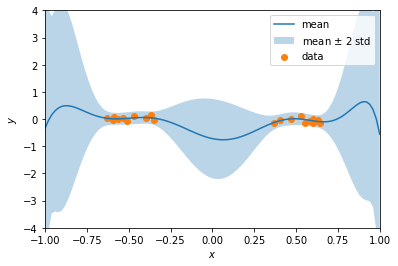

In [5]:
xs = t.linspace(-1, 1, 100)[:, None]
    
fig, ax = plt.subplots()
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_xlim(-1, 1)
ax.set_ylim(-4, 4)
    
PW = posterior(chebX(X, 10), Y, sigma, t.eye(10))
mean = chebX(xs, 10) @ PW.mean.T
cov = chebX(xs, 10) @ PW.covariance_matrix[0, :, :] @ chebX(xs, 10).T + sigma**2 * t.eye(xs.shape[0])
std = cov.diag()[:, None].sqrt()



ax.fill_between(xs[:, 0], (mean - 2*std)[:, 0], (mean + 2*std)[:, 0], alpha=0.3, label="mean $\pm$ 2 std")
ax.plot(xs, mean, label="mean")
ax.scatter(X, Y, label="data")
ax.legend();

<h2> How do we set the "hyperparameters" (e.g. $\sigma$), based on data? </h2>

We compute the "marginal likelihood",

\begin{align}
  \P{\y| \X} &= \int \mathbf{dw} \; \P{\y| \X, \w} \P{\w}
\end{align}

where,

\begin{align}
  \P{\y| \X, \w} &= \N{\y; \X \w, \sigma^2 \I}\\
  \P{\w} &= \N{\w; \0, \Sprior}
\end{align}

We can use a similar method as above (except that now things are much easier).

\begin{align}
  \y &= \X \w + \sigma \boldsymbol{\xi}\\
\end{align}

where $\P{\boldsymbol{\xi}} = \N{\boldsymbol{\xi}; \0, \I}$.

The expected value of $\y$ is therefore, $\0$,

\begin{align}
  \E{\y} &= \E{\X \w + \sigma \boldsymbol{\xi}}\\
  \E{\y} &= \X \E{\w}\\
  \E{\y} &= \0
\end{align}

And the variance of $\yt$ is,

\begin{align}
  \Cov{\y^T} &= \Cov{\X \w} + \sigma^2 \I\\
  \Cov{\y^T} &= \E{\X \w \w^T \X^T} + \sigma^2 \I\\
  \Cov{\y^T} &= \X \E{\w \w^T} \X^T + \sigma^2 \I \\
  \Cov{\y^T} &= \X \Sprior \X^T + \sigma^2 \I
\end{align}

Thus,

\begin{align}
  \P{\y| \X} &= \N{\y^T; \, \0, \, \X \Sprior \X^T + \sigma^2 \I}
\end{align}

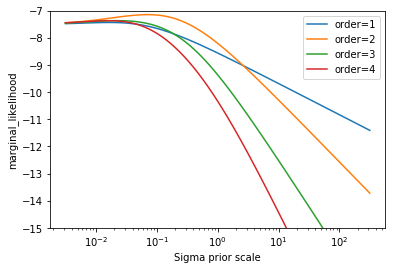

In [6]:
N     = 10  # number of datapoints
D     = 1   # dimension of datapoints
sigma = 0.5 # output noise
t.manual_seed(0)
rand  = t.rand(N, 1)
X     = 2*rand - 1
Wtrue = t.tensor([[0.2], [0.5]])
Y     = chebX(X, 2) @ Wtrue + sigma*t.randn(N, 1)

def marginal_likelihood(X, Y, sigma, order, Sigma_prior_scale):
    N = X.shape[0]
    Xe = chebX(X, order)
    Sprior = Sigma_prior_scale * t.eye(order)
    dist = MvNormal(t.zeros(N), Xe @ Sprior @ Xe.T + sigma**2*t.eye(N))
    return dist.log_prob(Y.T)

log_10_scales = t.linspace(-2.5, 2.5, 100)
scales = 10**log_10_scales
orders = t.arange(1, 10)

fig, ax = plt.subplots()
ax.set_xlabel("Sigma prior scale")
ax.set_ylabel("marginal_likelihood")
ax.set_xscale("log")
ax.set_ylim(-15, -7)

for order in range(1, 5):
    mls = t.tensor([marginal_likelihood(X, Y, sigma, order, scale) for scale in scales])
    ax.plot(scales, mls, label=f"order={order}")
ax.legend();

Interesting fact: the Bayesian model evidence can tell the difference between different functions, even when they're all well-regularised!